In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2
import random
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

2025-07-12 12:36:51.311401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752323811.529723      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752323811.592907      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ROOT = "/kaggle/input/teeth-dataset/Teeth_Dataset"
CATEGORIES = ["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]

# === Function to gather files ===
def get_file_paths_and_labels(subfolder):
    file_paths = []
    labels = []
    for idx, category in enumerate(CATEGORIES):
        category_path = os.path.join(ROOT, subfolder, category)
        for fname in os.listdir(category_path):
            file_paths.append(os.path.join(category_path, fname))
            labels.append(idx)
    return file_paths, labels

# === Get train/val/test ===
train_file_paths, train_labels = get_file_paths_and_labels("Training")
val_file_paths, val_labels = get_file_paths_and_labels("Validation")
test_file_paths, test_labels = get_file_paths_and_labels("Testing")

print(f"Train samples: {len(train_file_paths)}")
print(f"Validation samples: {len(val_file_paths)}")
print(f"Test samples: {len(test_file_paths)}")

Train samples: 3087
Validation samples: 1028
Test samples: 1028


I0000 00:00:1752323825.471310      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752323825.472033      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


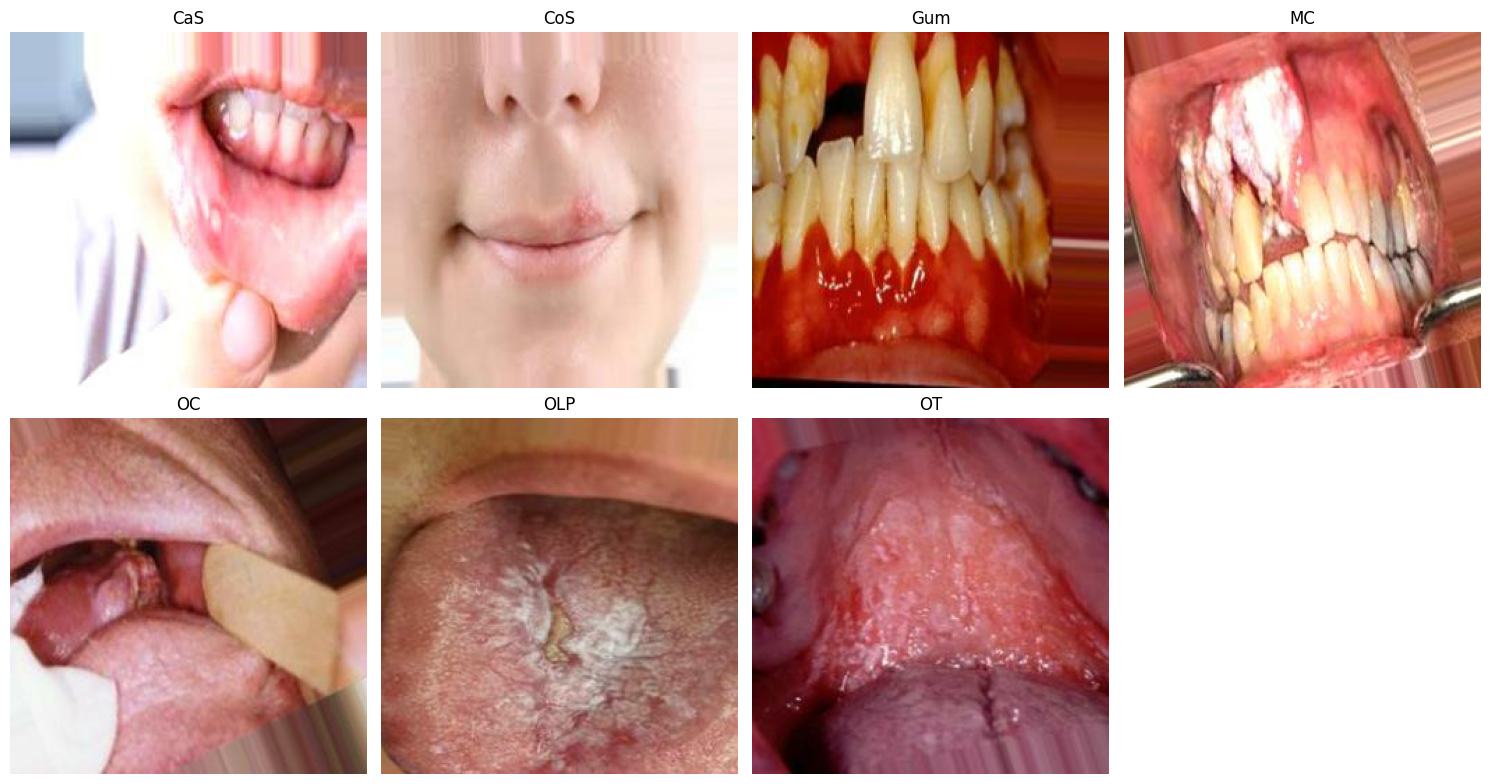

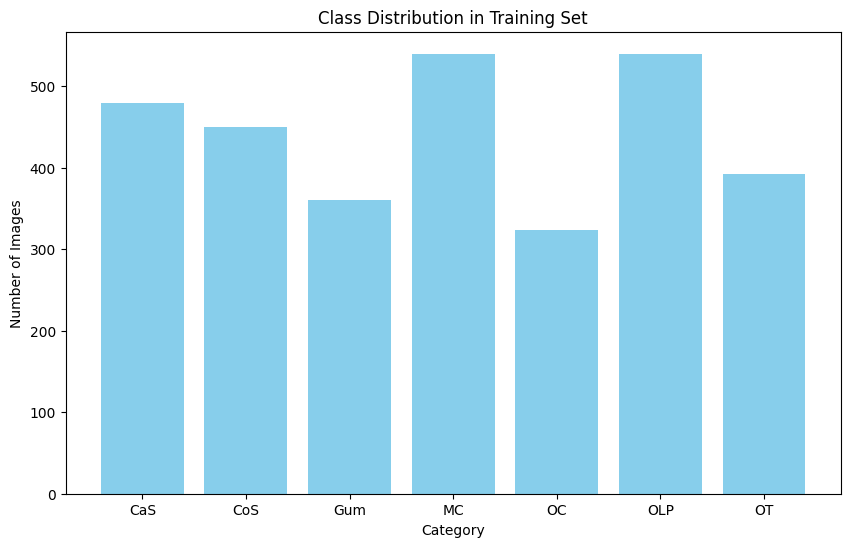

CaS: 480
CoS: 450
Gum: 360
MC: 540
OC: 324
OLP: 540
OT: 393


In [3]:
# Directory and categories
DATADIR = "/kaggle/input/teeth-dataset/Teeth_Dataset/Training"
CATEGORIES = ["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]

plt.figure(figsize=(15, 8))

for i, category in enumerate(CATEGORIES):
    path = os.path.join(DATADIR, category)
    imgs = os.listdir(path)

    if not imgs:
        print(f"No images found in {category}")
        continue

    img_name = random.choice(imgs)
    img_path = os.path.join(path, img_name)

    # Read and decode
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  # or decode_png if needed

    plt.subplot(2, (len(CATEGORIES)+1)//2, i+1)
    plt.imshow(img.numpy())
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Count the samples per category
counts = [train_labels.count(i) for i in range(len(CATEGORIES))]

plt.figure(figsize=(10, 6))
plt.bar(CATEGORIES, counts, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')
plt.show()

# ✅ Use CATEGORIES directly
for name, count in zip(CATEGORIES, counts):
    print(f"{name}: {count}")

In [4]:
# === Decode and preprocess ===
def decode_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256,256])
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# === Augment only for training ===
def fun_augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    return img, label

# === Create datasets ===
def prepare_dataset(file_paths, labels, augment=False, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(fun_augment, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(32)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [5]:
train_ds = prepare_dataset(train_file_paths, train_labels, augment=True, shuffle=True)
val_ds   = prepare_dataset(val_file_paths, val_labels)
test_ds  = prepare_dataset(test_file_paths, test_labels)

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',  # Monitor accuracy instead of loss
        patience=15,
        restore_best_weights=True,
        mode='max',
        min_delta=0.001
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='max'
    )
]

***# pretrained model***  

In [15]:
# Load pre-trained EfficientNetB0 WITHOUT the top classifier
base_model = ResNet50(
    input_shape=(256, 256, 3),
    weights='imagenet',
    include_top=False
)
print(f"Total layers: {len(base_model.layers)}")
# Freeze the base at first
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')
])


Total layers: 175


In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


I0000 00:00:1752324094.733554      99 service.cc:148] XLA service 0x782828004510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752324094.734664      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752324094.734688      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752324096.231155      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/97 ━━━━━━━━━━━━━━━━━━━━ 32:28 20s/step - accuracy: 0.0625 - loss: 3.1431

I0000 00:00:1752324102.290482      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 275ms/step - accuracy: 0.2658 - loss: 2.0947 - val_accuracy: 0.1274 - val_loss: 2.0983 - learning_rate: 0.0010
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.1308 - loss: 2.0215 - val_accuracy: 0.1274 - val_loss: 2.0579 - learning_rate: 0.0010
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.1314 - loss: 2.0068 - val_accuracy: 0.1751 - val_loss: 1.9416 - learning_rate: 0.0010
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.1481 - loss: 1.9463 - val_accuracy: 0.1751 - val_loss: 1.9391 - learning_rate: 0.0010
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.1524 - loss: 1.9474 - val_accuracy: 0.1751 - val_loss: 1.9372 - learning_rate: 0.0010
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.1638 - loss: 1.9317 - val_accuracy: 0.1751 - val_loss: 2.0988 - learning_rate: 0.0010
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.1317 - loss: 2.0209 - val_

In [20]:
base_model.trainable = True

# Optional: Freeze the first few layers if you don’t want to update ALL.
# Example: freeze first N layers
# for layer in base_model.layers[:100]:
#     layer.trainable = False

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # lower lr for fine-tuning!
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 143s 716ms/step - accuracy: 0.1499 - loss: 1.9395 - val_accuracy: 0.1586 - val_loss: 1.9426 - learning_rate: 1.0000e-05
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 440ms/step - accuracy: 0.1959 - loss: 1.8922 - val_accuracy: 0.1060 - val_loss: 1.9561 - learning_rate: 1.0000e-05
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 420ms/step - accuracy: 0.2879 - loss: 1.7983 - val_accuracy: 0.1449 - val_loss: 2.1326 - learning_rate: 1.0000e-05
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 433ms/step - accuracy: 0.3616 - loss: 1.6238 - val_accuracy: 0.1459 - val_loss: 2.0607 - learning_rate: 1.0000e-05
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 427ms/step - accuracy: 0.4343 - loss: 1.4898 - val_accuracy: 0.1362 - val_loss: 2.0090 - learning_rate: 1.0000e-05
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 452ms/step - accuracy: 0.4974 - loss: 1.3417 - val_accuracy: 0.2111 - val_loss: 1.9237 - learning_rate: 1.0000e-05
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 447ms/step - ac

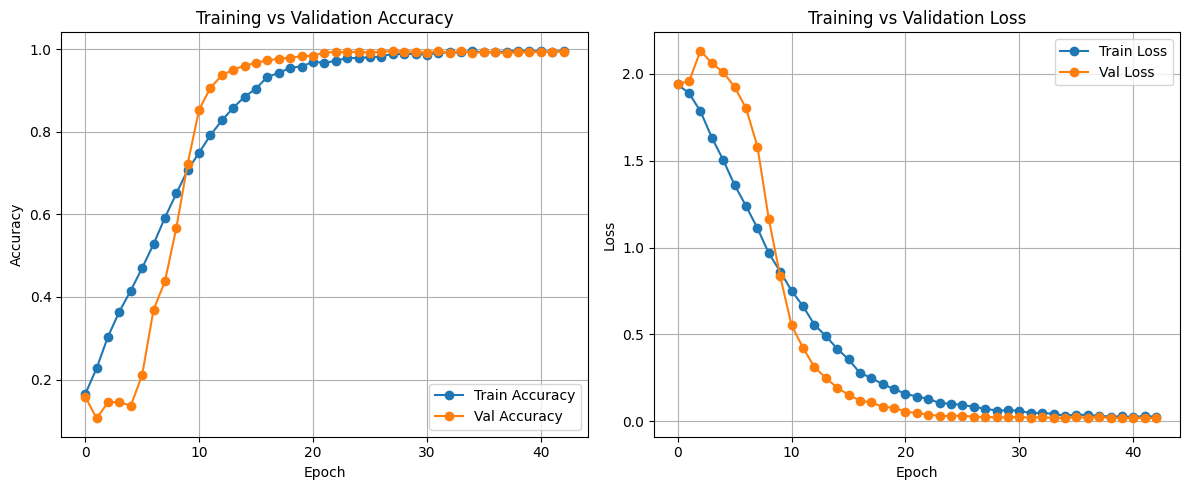

In [23]:
# === 1️⃣ Accuracy ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_fine.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# === 2️⃣ Loss ===
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Train Loss', marker='o')
plt.plot(history_fine.history['val_loss'], label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [24]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.9961 - loss: 0.0129
Test loss: 0.027689345180988312
Test accuracy: 0.9912451505661011


In [25]:
# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Predict probabilities
y_pred_probs = model.predict(test_ds)

# Get predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 231ms/step


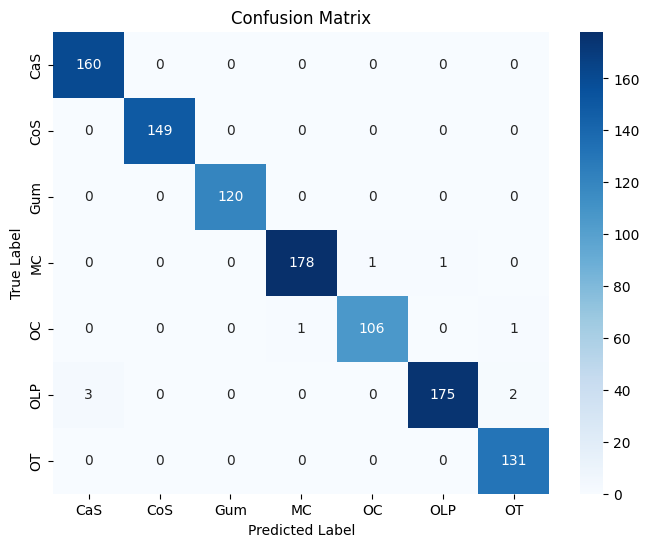

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CATEGORIES,
            yticklabels=CATEGORIES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [28]:
model.save("my_teeth_model.keras")